In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow import keras
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.7.0
2.7.0


In [2]:
from tensorflow.keras.layers.experimental import preprocessing

In [7]:
import pandas as pd

def load_data(data_path='data'):
    train_csv_path = os.path.join(data_path, "train.csv")
    test_csv_path = os.path.join(data_path, "test.csv")
    return pd.read_csv(train_csv_path, index_col='Id'), pd.read_csv(test_csv_path, index_col='Id')

train, test = load_data()

/home/marek/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
num_classes = train['Cover_Type'].nunique()
input_shape = (train.shape[1]-1)

In [30]:
train['Cover_Type'].nunique()

KeyError: 'Cover_Type'

In [12]:
y_train = train['Cover_Type']

In [27]:
train.drop('Cover_Type', axis=1, inplace=True)

In [28]:
train.shape

(4000000, 54)

In [29]:
test.shape

(1000000, 54)

In [20]:
y_binary = to_categorical(y_train.values-1)

In [31]:
y_binary.shape

(4000000, 7)

In [32]:
y_train

Id
0          1
1          2
2          1
3          2
4          2
          ..
3999995    2
3999996    2
3999997    2
3999998    3
3999999    1
Name: Cover_Type, Length: 4000000, dtype: int64

In [33]:
y_binary

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [34]:
input_shape

54

In [35]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[input_shape]),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(num_classes, activation='softmax'),
])


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               14080     
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 256)              

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [38]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.0005, patience=4, restore_best_weights=True)

In [66]:
batch_size = 1000
epochs = 2

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train, 
                    y_binary, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[early_stopping], 
                    validation_split=0.2,
                    workers=8,
                    use_multiprocessing=True,
                   )


Epoch 1/2
3200/3200 [==============================] - 31s 10ms/step - loss: 0.2371 - categorical_accuracy: 0.9069 - val_loss: 0.2557 - val_categorical_accuracy: 0.9038
Epoch 2/2
3200/3200 [==============================] - 31s 10ms/step - loss: 0.2355 - categorical_accuracy: 0.9072 - val_loss: 0.2619 - val_categorical_accuracy: 0.8987


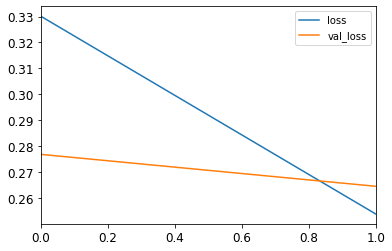

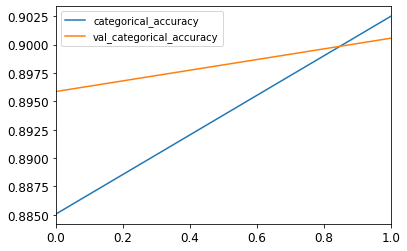

In [40]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()
# plt.ylim([0.985, 1.0])

In [67]:
predictions = model.predict(test)

In [68]:
predictions_cat = predictions.argmax(axis=1)+1

In [69]:
predictions_cat.shape

(1000000,)

In [70]:
predictions[0]

array([3.3217953e-03, 9.9490201e-01, 1.6957924e-03, 6.4859605e-06,
       1.2886135e-05, 3.1644566e-05, 2.9316863e-05], dtype=float32)

In [71]:
predictions_cat[0]

2

In [72]:
sub = pd.DataFrame({test.index.name: test.index, 'Cover_Type': predictions_cat})
sub.shape

(1000000, 2)

In [73]:
sub.to_csv("data/submission_05_first_approach_2.csv", index=False)

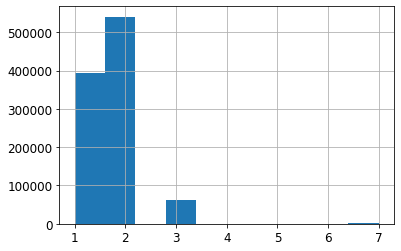

In [61]:
sub['Cover_Type'].hist()